In [1]:
import pandas as pd
import math

In [2]:
# Create a DataFrame containing all of the game info
# CSV file via Sports Reference https://www.sports-reference.com/cfb/years/2022-schedule.html

games = pd.read_csv("./games.csv", header="infer")
games.head()

,Rk,Wk,Date,Time,Day,Winner,Pts,Unnamed: 7,Loser,Pts.1,Notes
0,1,1,Aug 27 2022,7:00 PM,Sat,Florida Atlantic,43.0,NaN,Charlotte,13.0,NaN
1,2,1,Aug 27 2022,5:00 PM,Sat,Florida State,47.0,NaN,Duquesne,7.0,NaN
2,3,1,Aug 27 2022,4:00 PM,Sat,Illinois,38.0,NaN,Wyoming,6.0,NaN
3,4,1,Aug 27 2022,10:00 PM,Sat,Nevada,23.0,@,New Mexico State,12.0,NaN
4,5,1,Aug 27 2022,3:30 PM,Sat,Nevada-Las Vegas,52.0,NaN,Idaho State,21.0,NaN


In [3]:
# ranking methods
def cumulative_vs_rating(teams: pd.DataFrame, winner_row, loser_row, weight):
    
    l = (teams.loc[loser_row, 'vs_rating'].values[0])
    
    teams.loc[winner_row, 'vs_rating'] += (l / weight)
    
    return teams

def cumulative_vs_rating_logarithmic(teams: pd.DataFrame, winner_row, loser_row, base):
    
    l = (teams.loc[loser_row, 'vs_rating'].values[0])
    
    teams.loc[winner_row, 'vs_rating'] += .5 * math.log(math.sqrt(l), math.e) * math.sqrt(l)
    
    return teams

def cumulative_vs_rating_polynomial(teams: pd.DataFrame, winner_row, loser_row):
    
    l = (teams.loc[loser_row, 'vs_rating'].values[0])
    w = (teams.loc[winner_row, 'vs_rating'].values[0])
    
    teams.loc[winner_row, 'vs_rating'] += (1 / 1000000) * (abs(l - (0.3 * abs(w - 100))) ** 3.1) + 20   
    
    return teams

def cumulative_vs_rating_polynomial_with_penalty(teams: pd.DataFrame, winner_row, loser_row):
    
    l = (teams.loc[loser_row, 'vs_rating'].values[0])
    w = (teams.loc[winner_row, 'vs_rating'].values[0])
    
    teams.loc[winner_row, 'vs_rating'] += (1 / 1000000) * (abs(l - (0.3 * abs(w - 100))) ** 3.1) + 20
    teams.loc[loser_row, 'vs_rating'] -= min(max(((-1 * w) / 5) + 50, 10), 50)
    
    
    return teams

def cumulative_vs_rating_point_margin(teams: pd.DataFrame, winner_row, loser_row, game):
    
    l = (teams.loc[loser_row, 'vs_rating'].values[0])
    w = (teams.loc[winner_row, 'vs_rating'].values[0])
    
    winner_points = game['Pts']
    loser_points = game['Pts.1']
    
    margin = winner_points - loser_points
    if margin == 0:
        print(game)

    teams.loc[winner_row, 'vs_rating'] += (1 / 1000000) * (abs(l - (0.3 * abs((w - margin) - 100))) ** 3.1) + 20
    teams.loc[loser_row, 'vs_rating'] -= min(max(((-1 * w) / 5) + 50, 10), 30)
    
    
    return teams

# Ranking Systems
## Goals
- More weight placed on games later in season
- Take common opponents into account
- Remove bias for Power 5 teams

    ### Cumulative VS Rating
    - Adds a percentage of the losing team's rating to the winning team's rating for every game

        #### Benefits
        - Simple algorithm
        - Variable weight setting
        - Fair award for beating top, middle, and bottom tier teams
            
        #### Limits
        - Places too much emphasis on late-season games compared to early games
        - Common opponents not taken into account
        - No penalty for losing
        - Top teams are very close, very little distinction

        ##### Logarithmic variant
        + Larger variance between team ratings
        - Award for beating better team scales logarithmically, which is not ideal

        ##### Polynomial variant
        + Award increases exponentially for beating better teams
        + Good teams are awarded less for beating worse teams

        ##### Polynomial with penalty
        + Penalizes teams for losing, where losing to a worse team takes more points
        + More accurately depicts rankings of good teams with 1 or 2 losses
        
        ##### Polynomial with penalty and point margin
        + Slightly increases or decreases the award for the winning team based on the margin of victory


In [4]:
def remove_ranking(name): # remove the ranking from the team name (e.g. (15) Michigan)
    name = name.strip()
    if name[0] == "(":
        end = name.index(")")
        return name[end+2:]
    else:
        return name

def game_stats(teams, game): # populate the teams DF with the data from a given game
    winner = remove_ranking(game['Winner'])
    loser = remove_ranking(game['Loser'])
    
    winner_points = game['Pts']
    loser_points = game['Pts.1']
    
    if winner_points == 0 and loser_points == 0: # some of the points are 0 because the game was postponed
        return teams
    
    if not winner in set(teams['name']):
        temp = pd.DataFrame({"name": [winner], "games": [0], "wins": [0], "losses": [0], 'pts_for': [0], 'pts_against': [0], 'home_wins': [0], 'home_losses': [0], 'away_wins': [0], 'away_losses': [0], 'vs_rating': [100.0]})
        teams = pd.concat([teams, temp], ignore_index=True)
        
    winner_row = teams[teams['name'] == winner].index

    teams.loc[winner_row, 'wins'] += 1
    teams.loc[winner_row, 'games'] += 1
    
    
    if not loser in set(teams['name']):
        temp = pd.DataFrame({"name": [loser], "games": [0], "wins": [0], "losses": [0], 'pts_for': [0], 'pts_against': [0], 'home_wins': [0], 'home_losses': [0], 'away_wins': [0], 'away_losses': [0], 'vs_rating': [100.0]})
        teams = pd.concat([teams, temp], ignore_index=True)
        
    loser_row = teams[teams['name'] == loser].index
    
    teams.loc[loser_row, 'losses'] += 1
    teams.loc[loser_row, 'games'] += 1
    
    teams.loc[winner_row, 'pts_for'] += int(winner_points)
    teams.loc[winner_row, 'pts_against'] += int(loser_points)
    teams.loc[loser_row, 'pts_for'] += int(loser_points)
    teams.loc[loser_row, 'pts_against'] += int(winner_points)
    
    if game['Unnamed: 7'] == "@": # winning team is away
        teams.loc[winner_row, 'away_wins'] += 1
        teams.loc[loser_row, 'home_losses'] += 1
    else:
        teams.loc[winner_row, 'home_wins'] += 1
        teams.loc[loser_row, 'away_losses'] += 1
        
    teams = cumulative_vs_rating_point_margin(teams, winner_row, loser_row, game)
    teams = set_ranks(teams)
    
    return teams

def set_ranks(teams): # ranks the teams DF on the vs_rating column
    teams['vs_rank'] = teams['vs_rating'].rank(ascending=False)
    return teams

In [5]:
teams = pd.DataFrame(columns=['name', 'games', 'wins', 'losses', 'pts_for', 'pts_against', 'home_wins', 'home_losses', 'away_wins', 'away_losses', 'vs_rating', 'vs_rank'])

previous_games = games[games['Pts'].notna()] # take all of the games that have values for a score to remove the games that have not been played
for game in previous_games.iloc:
    teams = game_stats(teams, game)
    
teams.head()


,name,games,wins,losses,pts_for,pts_against,home_wins,home_losses,away_wins,away_losses,vs_rating,vs_rank
0,Florida Atlantic,12,5,7,357,319,4,2,1,5,-5.547713,203.0
1,Charlotte,12,3,9,293,473,1,5,2,4,-102.518111,220.0
2,Florida State,12,9,3,434,236,6,2,3,1,247.02129,21.0
3,Duquesne,2,0,2,21,71,0,0,0,2,40.0,182.5
4,Illinois,12,8,4,305,147,5,2,3,2,176.899313,41.0


In [6]:
teams.sort_values(by='vs_rating', ascending=False).take(range(25))

,name,games,wins,losses,pts_for,pts_against,home_wins,home_losses,away_wins,away_losses,vs_rating,vs_rank
117,Michigan,12,12,0,478,152,8,0,4,0,400.759473,1.0
64,Texas Christian,12,12,0,496,294,6,0,6,0,377.879734,2.0
91,Georgia,12,12,0,459,136,8,0,4,0,376.445705,3.0
131,Ohio State,12,11,1,534,231,7,1,4,0,336.579388,4.0
142,Southern California,12,11,1,510,316,7,0,4,1,336.358425,5.0
69,Alabama,12,10,2,489,216,7,0,3,2,315.04165,6.0
170,Clemson,12,10,2,412,251,6,1,4,1,302.098866,7.0
162,Washington,12,10,2,489,316,7,0,3,2,298.342455,8.0
47,Tennessee,12,10,2,568,282,7,0,3,2,296.088848,9.0
41,Penn State,12,10,2,430,216,6,1,4,1,294.988679,10.0


# Graph method
Another way to rank teams is by creating a weighted graph of all of the teams with the margin of victory as the weight of each edge.
The algorithm to rank nodes in the graph by on their weights is based on the Google PageRank algorithm. Learn more here- https://en.wikipedia.org/wiki/PageRank

#### Benefits
- Takes into account common opponents and point margins
- Makes analysis beyond just each game played by a team using the graph network

#### Limitations
- Does not work well for teams with fewer games played

In [7]:
# creates csv file used for the graph
# only takes the data needed for the graph

import csv

file = open('game_results.csv', 'w+')
writer = csv.writer(file)
header = ['winner','loser','weight']
writer.writerow(header)

for game in previous_games.iloc:
    winner = remove_ranking(game['Winner'])
    loser = remove_ranking(game['Loser'])
    
    winner_points = game['Pts']
    loser_points = game['Pts.1']
    margin = winner_points - loser_points
    writer.writerow([winner, loser, margin])
    
file.close()

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({
    'figure.figsize': (9, 9),
    'axes.spines.right': False,
    'axes.spines.left': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False})
import networkx as nx
import pandas as pd
import numpy as np

inlinks_csv = 'game_results.csv'
games = pd.read_csv(inlinks_csv)
games

,winner,loser,weight
0,Florida Atlantic,Charlotte,30.0
1,Florida State,Duquesne,40.0
2,Illinois,Wyoming,32.0
3,Nevada,New Mexico State,11.0
4,Nevada-Las Vegas,Idaho State,31.0
...,...,...,...
839,Utah,Colorado,42.0
840,Virginia,Virginia Tech,0.0
841,Washington,Washington State,18.0
842,West Virginia,Oklahoma State,5.0


In [9]:
G_weighted=nx.from_pandas_edgelist(games, 'winner', 'loser', create_using=nx.DiGraph, edge_attr='weight')
G=nx.from_pandas_edgelist(games, 'winner', 'loser', create_using=nx.DiGraph, edge_attr=None)
# create a weighted and unweighted graph of every game

In [10]:
invalid_teams_G = [node for node in G.nodes if (G.out_degree(node) + G.in_degree(node)) < 9]
G.remove_nodes_from(invalid_teams_G)

invalid_teams_G_weighted = [node for node in G_weighted.nodes if (G_weighted.out_degree(node) + G_weighted.in_degree(node)) < 9]
G_weighted.remove_nodes_from(invalid_teams_G_weighted)

# remove all of the teams that have fewer than 9 games played
# the number can be changed to accomodate for different parts of the season

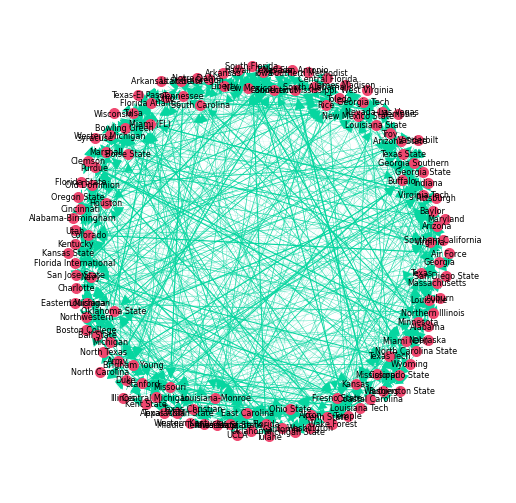

In [11]:
weights = [i/50 for i in games['weight'].tolist()]

pos = nx.spring_layout(G_weighted, k=10000)
nx.draw_networkx_edges(G_weighted, pos, edge_color='#06D6A0', arrowsize=22, width=weights)
nx.draw_networkx_nodes(G_weighted, pos,node_color='#EF476F', node_size=100)
nx.draw_networkx_labels(G_weighted, pos, font_size=8, font_weight='normal', font_color='black')
plt.gca().margins(0.1, 0.1)
plt.show()

In [18]:
unweighted_rating = nx.pagerank(G, alpha=0.85) 
weighted_rating = nx.pagerank(G_weighted, alpha=0.85)
# use nx.pagerank to create a rank for each team
# scale by 0.9 for each to consider the score and the W/L result for the graph and so the graph rating is scaled similarly to the vs rating

teams_metrics = pd.DataFrame(dict(
    unweighted_rating = unweighted_rating,
    weighted_rating = weighted_rating,
))
teams_metrics['graph_rating'] = teams_metrics['unweighted_rating'] + teams_metrics['weighted_rating']
# graph_rating is the sum of the weighted and unweighted rating

teams_metrics['name'] = teams_metrics.index

teams_metrics['graph_rank'] = teams_metrics['graph_rating'].rank(ascending=True, method='first')
teams_metrics.sort_values('graph_rank', ascending=True, ).take(range(25))

,unweighted_rating,weighted_rating,graph_rating,name,graph_rank
Texas Christian,0.001399,0.001375,0.002774,Texas Christian,1.0
Georgia,0.001399,0.001375,0.002774,Georgia,2.0
Michigan,0.001399,0.001375,0.002774,Michigan,3.0
Ohio State,0.001498,0.001454,0.002952,Ohio State,4.0
Southern California,0.001679,0.001383,0.003062,Southern California,5.0
Penn State,0.001614,0.001511,0.003125,Penn State,6.0
Alabama,0.001936,0.001410,0.003346,Alabama,7.0
South Alabama,0.002116,0.001477,0.003593,South Alabama,8.0
Kansas State,0.002130,0.001608,0.003738,Kansas State,9.0
Texas-San Antonio,0.002255,0.001628,0.003883,Texas-San Antonio,10.0


In [19]:
df = pd.merge(teams, teams_metrics, on='name') # combine the vs ratings dataframe and the graph ratings dataframe
df = df.drop(columns=['home_wins', 'away_wins', 'home_losses', 'away_losses', 'unweighted_rating', 'weighted_rating'])
df.sort_values(by='graph_rank').take(range(25))

,name,games,wins,losses,pts_for,pts_against,vs_rating,vs_rank,graph_rating,graph_rank
48,Texas Christian,12,12,0,496,294,377.879734,2.0,0.002774,1.0
67,Georgia,12,12,0,459,136,376.445705,3.0,0.002774,2.0
86,Michigan,12,12,0,478,152,400.759473,1.0,0.002774,3.0
98,Ohio State,12,11,1,534,231,336.579388,4.0,0.002952,4.0
108,Southern California,12,11,1,510,316,336.358425,5.0,0.003062,5.0
30,Penn State,12,10,2,430,216,294.988679,10.0,0.003125,6.0
51,Alabama,12,10,2,489,216,315.04165,6.0,0.003346,7.0
105,South Alabama,12,10,2,383,233,264.800002,15.0,0.003593,8.0
76,Kansas State,12,9,3,401,233,266.374359,14.0,0.003738,9.0
71,Texas-San Antonio,12,10,2,455,318,247.133193,20.0,0.003883,10.0


In [20]:
df['normalized_graph_rating'] = df['graph_rating'].map(lambda r: 1/r)
df['final_rating'] = df['normalized_graph_rating'] + df['vs_rating']

df['final_rank'] = df['final_rating'].rank(ascending=False, method='first')
df.sort_values(by='final_rank').take(range(25))

,name,games,wins,losses,pts_for,pts_against,vs_rating,vs_rank,graph_rating,graph_rank,normalized_graph_rating,final_rating,final_rank
86,Michigan,12,12,0,478,152,400.759473,1.0,0.002774,3.0,360.458591,761.218064,1.0
48,Texas Christian,12,12,0,496,294,377.879734,2.0,0.002774,1.0,360.458591,738.338325,2.0
67,Georgia,12,12,0,459,136,376.445705,3.0,0.002774,2.0,360.458591,736.904297,3.0
98,Ohio State,12,11,1,534,231,336.579388,4.0,0.002952,4.0,338.727270,675.306659,4.0
108,Southern California,12,11,1,510,316,336.358425,5.0,0.003062,5.0,326.609026,662.967451,5.0
30,Penn State,12,10,2,430,216,294.988679,10.0,0.003125,6.0,320.040391,615.02907,6.0
51,Alabama,12,10,2,489,216,315.04165,6.0,0.003346,7.0,298.826007,613.867658,7.0
35,Tennessee,12,10,2,568,282,296.088848,9.0,0.004037,11.0,247.694904,543.783752,8.0
105,South Alabama,12,10,2,383,233,264.800002,15.0,0.003593,8.0,278.314966,543.114968,9.0
76,Kansas State,12,9,3,401,233,266.374359,14.0,0.003738,9.0,267.520748,533.895108,10.0


# Conclusion
Many of the rankings using these algorithms are very close to what would be expected for the top teams. There are some outliers, such as Texas-San Antonio and Troy, because they have good records, did not play any top teams, and had a long path from any teams that would be better. More simply, they were very good compared to the group of teams they played, mainly consisting of teams from their respective conference. 

The VS Ranking alone would not take into account matchups between two teams; it only considers whether a team wins or loses rather than *who* they win or lose to. The Graph Ranking would work very well if there were more games and teams played a broader range of opponents. Because most of the sesason consists of conference games, teams that perform well in their conference would have an inflated ranking in the graph compared to their actual level of play. Combining both of these ranking systems fixes most problems, though some tweaking to the VS Ranking equations and some constants in the Graph Ranking could provide a better result.

This tool could be useful for predicting the top 25 teams before the polls are released. It also shows some instances in which the polls favor certain teams based on prior success and television ratings. 